In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
import random
import pickle

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


## 1. Loading and inspecting the data

In [22]:
input_data = pd.read_csv("aki_data/test_data.tsv", sep="\t")
input_data_preprocessed = pd.read_csv("aki_data/test_qm.csv")
translation = pd.read_csv("aki_data/translation.tsv", sep="\t", index_col=0)
pathways = pd.read_csv("aki_data/pathways.tsv", sep="\t")
design_matrix = pd.read_csv("aki_data/design_matrix.tsv", sep="\t")

In [23]:
input_data_preprocessed.head()

,Protein,TM_P1911_190,TM_P1911_191,TM_P1911_192,TM_P1911_193,TM_P1911_194,TM_P1911_196,TM_P1911_197,TM_M2012_010,TM_M2012_011,...,TM_M2012_190,TM_M2012_191,TM_M2012_192,TM_M2012_196,TM_M2012_197,TM_M2012_198,TM_M2012_199,TM_M2012_200,TM_M2012_202,TM_M2012_203
0,P08603,22.381866,22.773908,22.732549,22.960530,22.906198,23.167862,23.122564,23.110142,23.179716,...,23.416677,23.498007,23.459972,23.403313,23.454894,23.602666,23.682634,23.665858,24.015710,23.655648
1,P02671,25.349974,25.431340,25.459891,25.275259,25.592789,24.829806,24.208987,23.984077,26.075865,...,24.984516,25.023149,24.971465,23.369445,24.604836,24.623221,24.787905,25.095571,25.103341,24.914344
2,P01042,22.061788,21.872170,21.966596,22.256140,22.505168,22.993978,23.277504,22.963205,22.767097,...,22.953879,23.089170,23.018547,23.280626,23.503529,23.471356,23.471414,23.193750,24.101306,23.486766
3,P00450,22.647246,23.193086,23.332780,23.206429,22.959381,23.008403,22.770807,22.971128,23.373016,...,23.788756,23.932623,23.904721,23.273831,23.462794,23.783564,23.968122,23.956618,23.989086,23.834912
4,P05156,21.301448,21.435684,21.304184,21.459141,21.532018,22.006447,21.968122,21.688934,21.372610,...,21.850530,21.883567,21.936084,21.778412,22.051000,22.187546,21.965964,21.820840,22.373783,22.076671


In [20]:
# get head of 10 first columns of input data
columns = input_data.columns[:10]
# get head of 10 first rows of input data
input_data[columns][:10]

,PeptideSequence,Charge,Decoy,Protein,CK_P1912_146,CK_P1912_147,CK_P1912_148,CK_P1912_150,CK_P1912_151,CK_P1912_152
0,VDRDVAPGTLC(UniMod:4)DVAGWGIVNHAGR,3,False,P00746,7238870.0,NaN,NaN,NaN,NaN,NaN
1,VDRDVAPGTLC(UniMod:4)DVAGWGIVNHAGR,4,False,P00746,2681940.0,2634110.0,2297470.0,1935300.0,2181160.0,2615960.0
2,VDTVDPPYPR,2,False,P04004,28535800.0,34874600.0,34586900.0,25820800.0,24657400.0,30830100.0
3,AVTEQGAELSNEER,2,False,P27348,NaN,NaN,NaN,NaN,NaN,NaN
4,VDVIPVNLPGEHGQR,2,False,P02751,652100.0,NaN,NaN,NaN,NaN,NaN
5,VDVIPVNLPGEHGQR,3,False,P02751,2465680.0,3161150.0,1659760.0,1342500.0,2004230.0,2126690.0
6,AVTEQGAELSNEER,3,False,P27348,NaN,NaN,NaN,NaN,NaN,NaN
7,VDVQAGAC(UniMod:4)EGK,2,False,P0C0L4,NaN,11320100.0,8561070.0,7999110.0,NaN,11342800.0
8,VDVQAGAC(UniMod:4)EGKLELSVDGAK,2,False,P0C0L4,NaN,NaN,NaN,NaN,NaN,NaN
9,VDVQAGAC(UniMod:4)EGKLELSVDGAK,3,False,P0C0L4,4027070.0,22590200.0,9574710.0,2521140.0,9968220.0,16477800.0


In [10]:
translation.head()

,input,translation
1323,A0A075B6P5,R-HSA-166663
1324,A0A075B6P5,R-HSA-173623
1325,A0A075B6P5,R-HSA-198933
1326,A0A075B6P5,R-HSA-202733
1327,A0A075B6P5,R-HSA-2029481


In [15]:
design_matrix.head()

,sample,group
0,TM_P1911_190,2
1,TM_P1911_191,2
2,TM_P1911_192,2
3,TM_P1911_193,2
4,TM_P1911_194,2


In [52]:
pathways

,parent,child
0,R-HSA-109581,R-HSA-109606
1,R-HSA-109581,R-HSA-169911
2,R-HSA-109581,R-HSA-5357769
3,R-HSA-109581,R-HSA-75153
4,R-HSA-109582,R-HSA-140877
...,...,...
2598,R-HSA-983705,R-HSA-983695
2599,R-HSA-983712,R-HSA-2672351
2600,R-HSA-983712,R-HSA-936837
2601,R-HSA-991365,R-HSA-170670


## 2. Creating the Graphs

### 2.0 Create Hierarchical Pathway Graph

In [65]:
G = nx.DiGraph()
for _, row in pathways.iterrows():
    G.add_edge(row['parent'], row['child'])

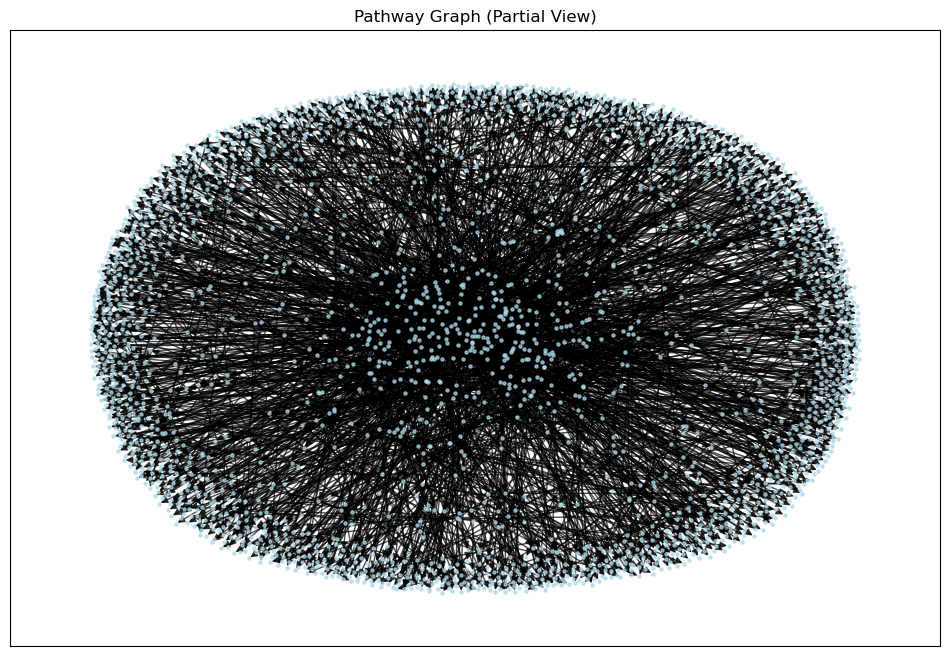

In [21]:
plt.figure(figsize=(12, 8))
nx.draw_networkx(G, with_labels=False, node_size=5, node_color='lightblue', alpha=0.7)
plt.title("Pathway Graph (Partial View)")
plt.show()

### 2.1 Graph type 1: Mapping proteins only to first level of pathways

#### 2.1.1 Map Proteins to Pathways

In [66]:
for _, row in translation.iterrows():
    protein = row['input']  
    pathway = row['translation'] 
    if pathway in G:
        if 'proteins' not in G.nodes[pathway]:  
            G.nodes[pathway]['proteins'] = []
        G.nodes[pathway]['proteins'].append(protein)


In [67]:
num_empty_nodes = 0
for node in G.nodes():
    if 'proteins' not in G.nodes[node]:
        num_empty_nodes += 1
num_empty_nodes

492

#### 2.1.2 Integrate Patient Data and save to file

In [29]:
patient_ids = input_data_preprocessed.columns[1:]
for patient_id in patient_ids:
    patient_graph = G.copy()
    for _, row in input_data_preprocessed.iterrows():
        protein = row['Protein']  # Assuming 'Protein' column contains protein IDs
        abundance = row[patient_id]  # Protein abundance for this patient
        # For each pathway associated with this protein, update the graph
        for pathway in patient_graph.nodes:
            if 'proteins' in patient_graph.nodes[pathway] and protein in patient_graph.nodes[pathway]['proteins']:
                if 'abundance' not in patient_graph.nodes[pathway]:
                    patient_graph.nodes[pathway]['abundance'] = 0
                patient_graph.nodes[pathway]['abundance'] += abundance
    # save each patitent graph to a pickle file in graph folder
    with open('graph_data/patient_graph_' + patient_id + '.pkl', 'wb') as f:
        pickle.dump(patient_graph, f)


#### 2.1.3 Visualize sample patient graph

/var/folders/vn/mllgs9t95s722nyhhjxsd_vr0000gp/T/ipykernel_83772/239062610.py:2: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  sampled_nodes = random.sample(patient_graph.nodes(), 500)  # Sample 50 nodes


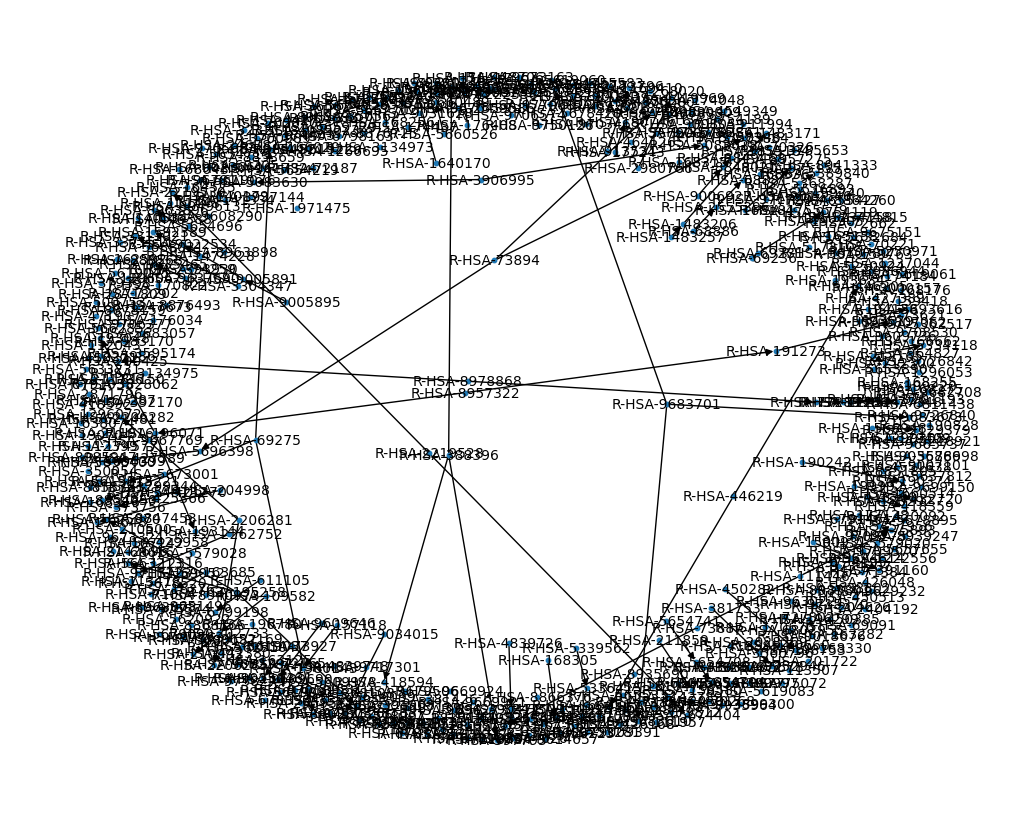

In [69]:
# Sample a subset of all nodes
sampled_nodes = random.sample(patient_graph.nodes(), 500)  # Sample 50 nodes
subgraph = patient_graph.subgraph(sampled_nodes)

# Plotting
plt.figure(figsize=(10, 8))
nx.draw(subgraph, with_labels=True, node_size=10, font_size=10)
plt.show()

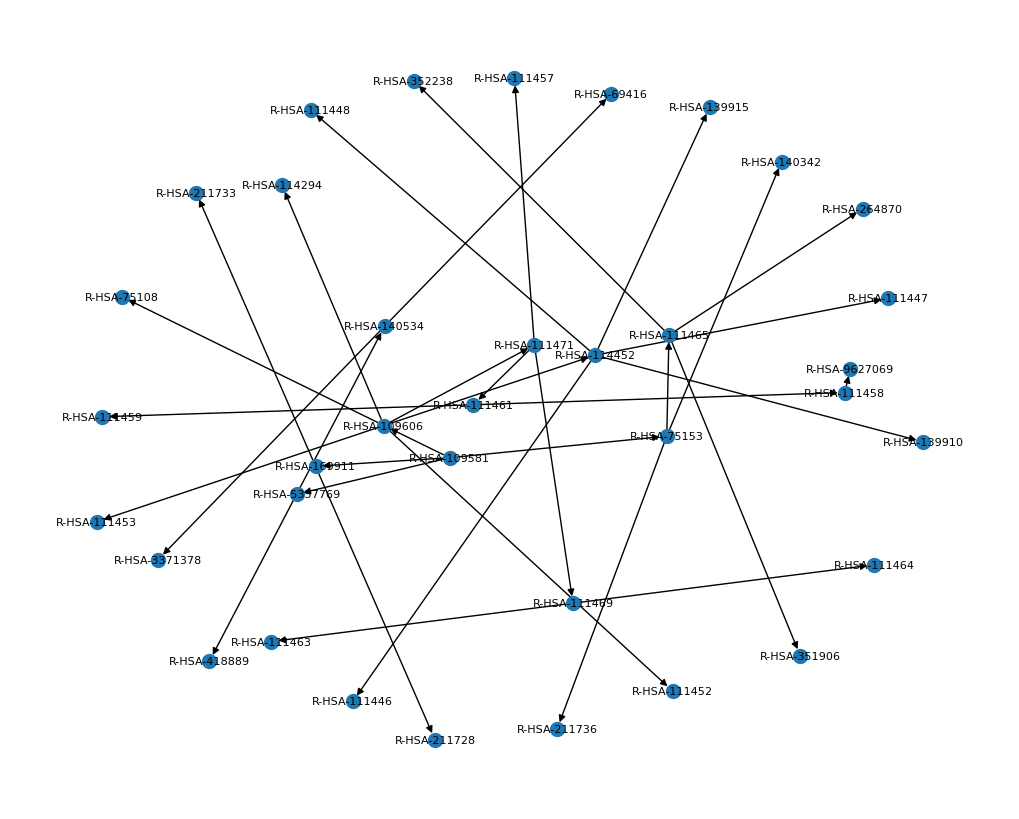

In [70]:
def extract_branch(graph, root_node, max_depth):
    nodes = set()
    for depth in range(max_depth + 1):
        descendants = nx.descendants_at_distance(graph, root_node, depth)
        nodes.update(descendants)
    nodes.add(root_node)
    return graph.subgraph(nodes)

# Example usage
root_node = 'R-HSA-109581' # Replace with the actual root node of the branch
max_depth = 5  # Adjust as needed
branch = extract_branch(patient_graph, root_node, max_depth)

# Plotting the branch
plt.figure(figsize=(10, 8))
nx.draw(branch, with_labels=True, node_size=100, font_size=8)
plt.show()

### 2.2 Graph type 2: Mapping proteins to all levels of pathways

In [73]:
G = nx.DiGraph()
for _, row in pathways.iterrows():
    G.add_edge(row['parent'], row['child'])

In [74]:
# getting descandants of all pathways
descendants = {}
for node in G.nodes():
    descendants[node] = nx.descendants(G, node)

In [75]:
for _, row in translation.iterrows():
    protein = row['input']  
    pathway = row['translation']
    if pathway in G:
        # Ensure the 'proteins' attribute exists for the pathway
        G.nodes[pathway].setdefault('proteins', []).append(protein)

        # Iterate through descendants and assign proteins
        for descendant in nx.descendants(G, pathway):
            G.nodes[descendant].setdefault('proteins', []).append(protein)


In [ ]:
patient_ids = input_data_preprocessed.columns[1:]
for patient_id in patient_ids:
    patient_graph = G.copy()
    for _, row in input_data_preprocessed.iterrows():
        protein = row['Protein']  # Assuming 'Protein' column contains protein IDs
        abundance = row[patient_id]  # Protein abundance for this patient
        # For each pathway associated with this protein, update the graph
        for pathway in patient_graph.nodes:
            if 'proteins' in patient_graph.nodes[pathway] and protein in patient_graph.nodes[pathway]['proteins']:
                if 'abundance' not in patient_graph.nodes[pathway]:
                    patient_graph.nodes[pathway]['abundance'] = 0
                patient_graph.nodes[pathway]['abundance'] += abundance
    # save each patitent graph to a pickle file in graph folder
    with open('graph_data/patient_graph_' + patient_id + '.pkl', 'wb') as f:
        pickle.dump(patient_graph, f)

In [76]:
# check if proteins are also assigned to child nodes
# count number of non empty nodes
num_empty_nodes = 0
for node in G.nodes():
    if 'proteins' not in G.nodes[node]:
        num_empty_nodes += 1
num_empty_nodes

424

## 3. Analze design matrix

In [94]:
design_matrix.head()

,sample,group
0,TM_P1911_190,2
1,TM_P1911_191,2
2,TM_P1911_192,2
3,TM_P1911_193,2
4,TM_P1911_194,2


In [75]:
# get number of samples in group 1 and group 2
group1 = design_matrix[design_matrix['group'] == 1]
group2 = design_matrix[design_matrix['group'] == 2]
group1_num = len(group1)
group2_num = len(group2)

print("group1_num: ", group1_num)
print("group2_num: ", group2_num)


group1_num:  74
group2_num:  123


In [93]:
# get num of smaples that have 'M2012' in thgeir id
group_M2012 = design_matrix[design_matrix['sample'].str.contains('M2012')]

print("group_M2012: ", len(group_M2012))
print("remaining samples: ", len(design_matrix) - len(group_M2012))

group_M2012:  141
remaining samples:  56
